# GARCH model

The difference between the garch model and the ARCH model is that the GARCH model considers the previous variance in the model. The GARCH model is defined as follows:

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where $\omega$, $\alpha$, and $\beta$ are the parameters of the model, and $\epsilon_{t-1}^2$ is the residual of the previous period.



In [1]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Garch model (2, 2)

The Garch model (2, 2) is defined as follows:

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2
$$

where $\omega$, $\alpha_1$, $\alpha_2$, $\beta_1$, and $\beta_2$ are the parameters of the model, and $\epsilon_{t-1}^2$ and $\epsilon_{t-2}^2$ are the residuals of the previous periods.

$$
\epsilon_t \sim N(0, \sigma_t^2)
$$


In [2]:
# Create dataset 
np.random.seed(0)
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n * 0.1)

series = [gauss(0, 1), gauss(0,1)]
vols = [1,1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1 * series[-1]**2 + alpha_2 * series[-2]**2 + beta_1 * vols[-1]**2 + beta_2 * vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    series.append(new_val)
    vols.append(new_vol)


Text(0.5, 1.0, 'Simulated GARCH(2,2) series')

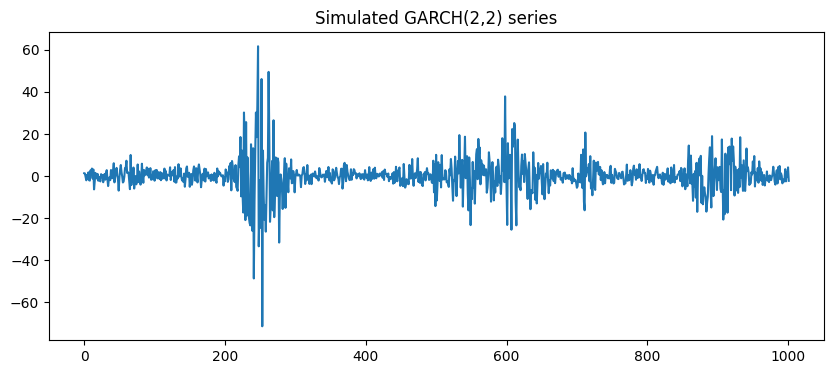

In [3]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Simulated GARCH(2,2) series')

Text(0.5, 1.0, 'Simulated GARCH(2,2) series with conditional volatility')

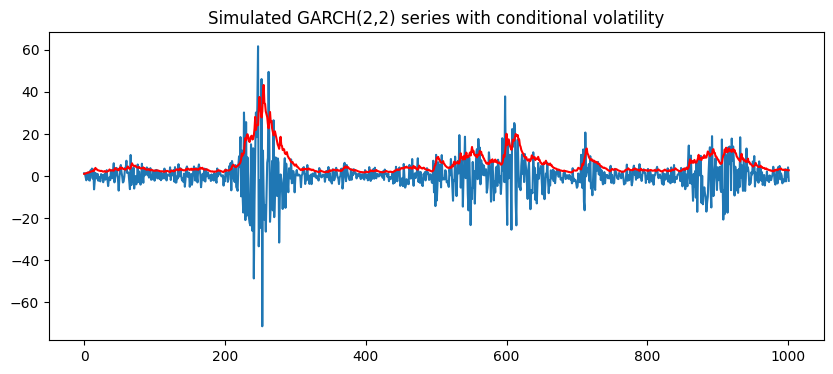

In [4]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.plot(vols, color='red')
plt.title('Simulated GARCH(2,2) series with conditional volatility')

### PACF

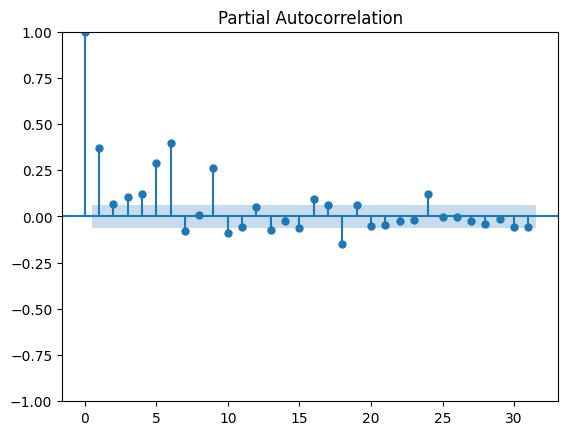

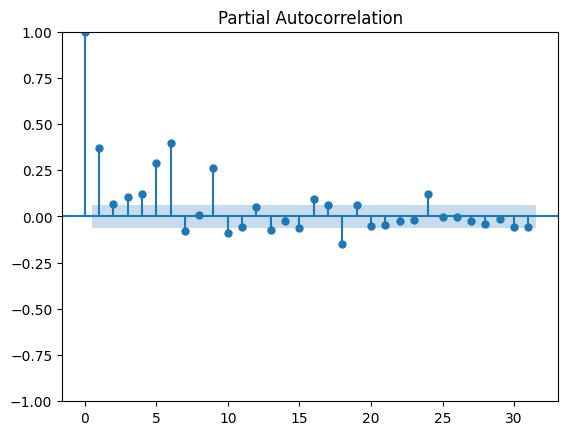

In [5]:
plot_pacf(np.array(series) ** 2)

In [6]:
train, test = series[:-test_size], series[-test_size:]

In [7]:
model = arch_model(train, p=2, q=2)

In [8]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2681350940.563995
Iteration:      2,   Func. Count:     17,   Neg. LLF: 10818611658.54238
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3421.357554410422
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2910.4305530288416
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2706.961564085039
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2747.0582623094674
Iteration:      7,   Func. Count:     58,   Neg. LLF: 2626.0556899454223
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2622.815089858689
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2604.4756138538196
Iteration:     10,   Func. Count:     82,   Neg. LLF: 2626.085236427102
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2602.9930922477065
Iteration:     12,   Func. Count:     97,   Neg. LLF: 2602.4376843068553
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2602.3360615894635
Iteration:     14,   Func. Count:    111,   Neg. LLF: 260

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2602.32
Distribution:                  Normal   AIC:                           5216.65
Method:            Maximum Likelihood   BIC:                           5245.47
                                        No. Observations:                  902
Date:                Mon, Dec 02 2024   Df Residuals:                      901
Time:                        01:01:32   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1085  9.567e-02      1.134      0.257 [-7.897e-02,  0.296]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5482      0.233      2.353  1.861e-02  [9.163e-02,  1.005]
alpha[1]       0.1245  5.496e-02      2.266  2.345e-02  [1.682e-02,  0.232]
alpha[2]       0.1954      0.112      1.745  8.090e-02 [-2.401e-02,  0.415]
beta[1]        0.4930      0.386      1.279      0.201    [ -0.263,  1.249]
beta[2]        0.1871      0.296      0.633      0.527    [ -0.392,  0.766]
===========================================================================

Covariance estimator: robust
"""

## Predict

In [10]:
predictions = model_fit.forecast(horizon=test_size)

Text(0.5, 1.0, 'True vs predicted volatility')

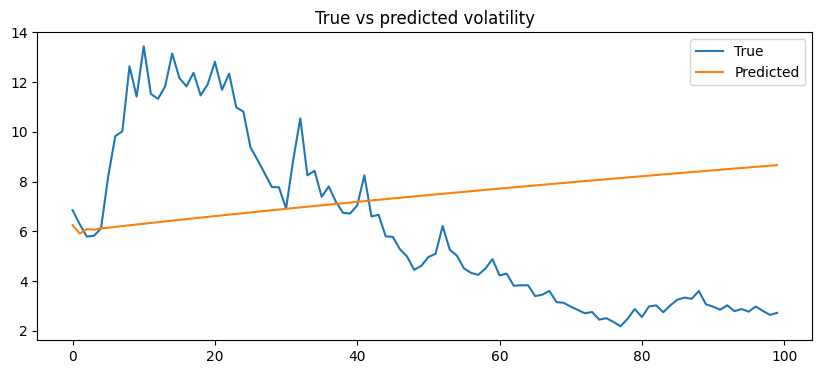

In [11]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label='True')
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]), label='Predicted')
plt.legend(handles=[true, preds])
plt.title('True vs predicted volatility')

### Rolling forecasting

Basically, we want to predict the next value with the information available. so for each time step, we use the info, then we do a step and redo the model.

In [12]:
rolling_prediction = []
for i in range(test_size):
    train = series[:-test_size+i]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    pred = model_fit.forecast(horizon=1)
    rolling_prediction.append(np.sqrt(pred.variance.values[-1, 0]))

Text(0.5, 1.0, 'True vs rolling predicted volatility')

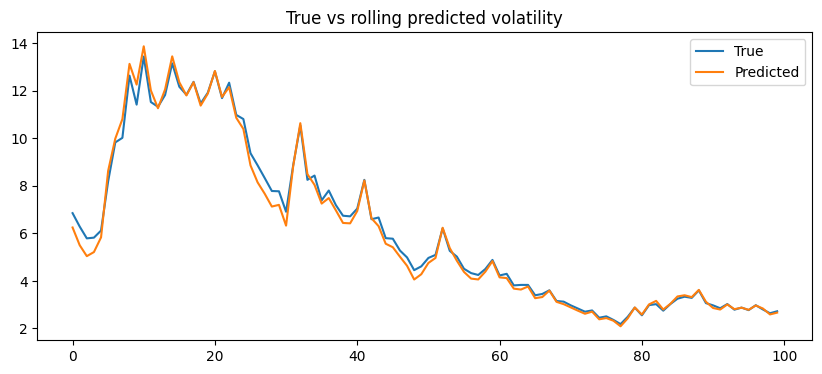

In [13]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label='True')
preds, = plt.plot(rolling_prediction, label='Predicted')
plt.legend(handles=[true, preds])
plt.title('True vs rolling predicted volatility')

In [14]:
from sklearn.metrics import mean_squared_error

mean_squared_error(vols[-test_size:], rolling_prediction)

np.float64(0.08774194582444578)

# SARIMA

## How to detect seasons

In [33]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

### Data generation

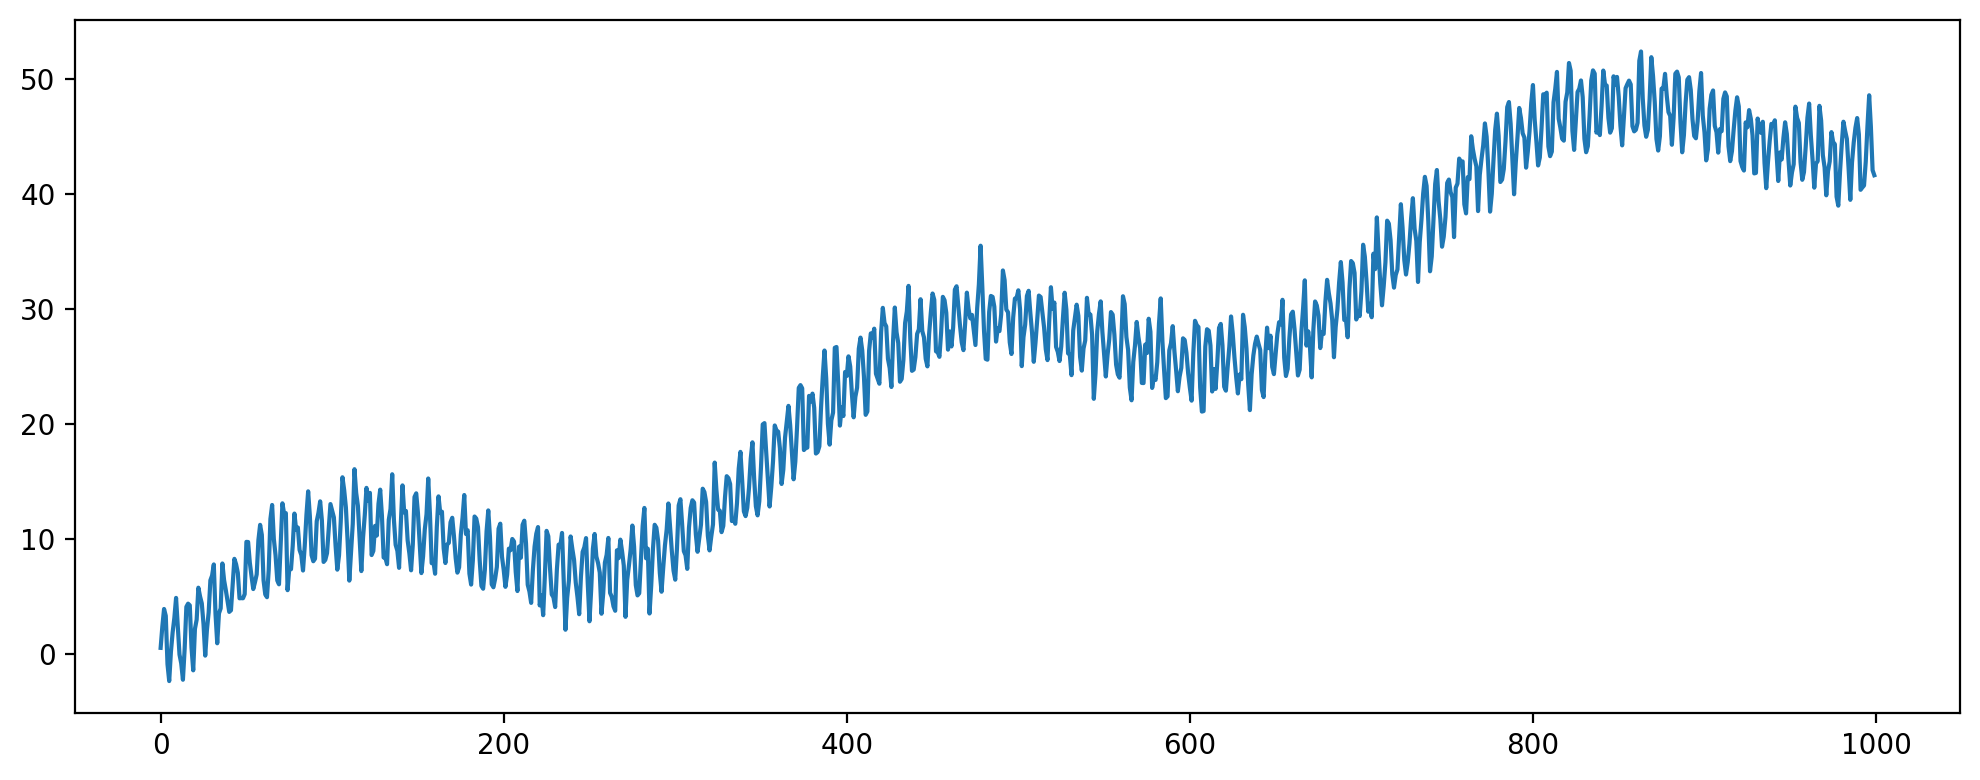

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_squared_error

# Simulate some example data
np.random.seed(42)
n_obs = 1000

# Simulate a time series with trend, seasonality, and noise
time = np.arange(n_obs)
seasonality =  6 * np.sin(2 * np.pi * time / 365)  # Annual seasonality
seasonality += 3 * np.sin(2 * np.pi * time / 7)  # Weekly seasonality
trend = 0.05 * time  # Linear trend
noise = np.random.normal(0, 1, n_obs)  # Random noise
data = trend + seasonality + noise

# Create a DataFrame
data = pd.DataFrame(data, columns=['value'])

plt.figure(figsize=(10, 4))
plt.plot(data)

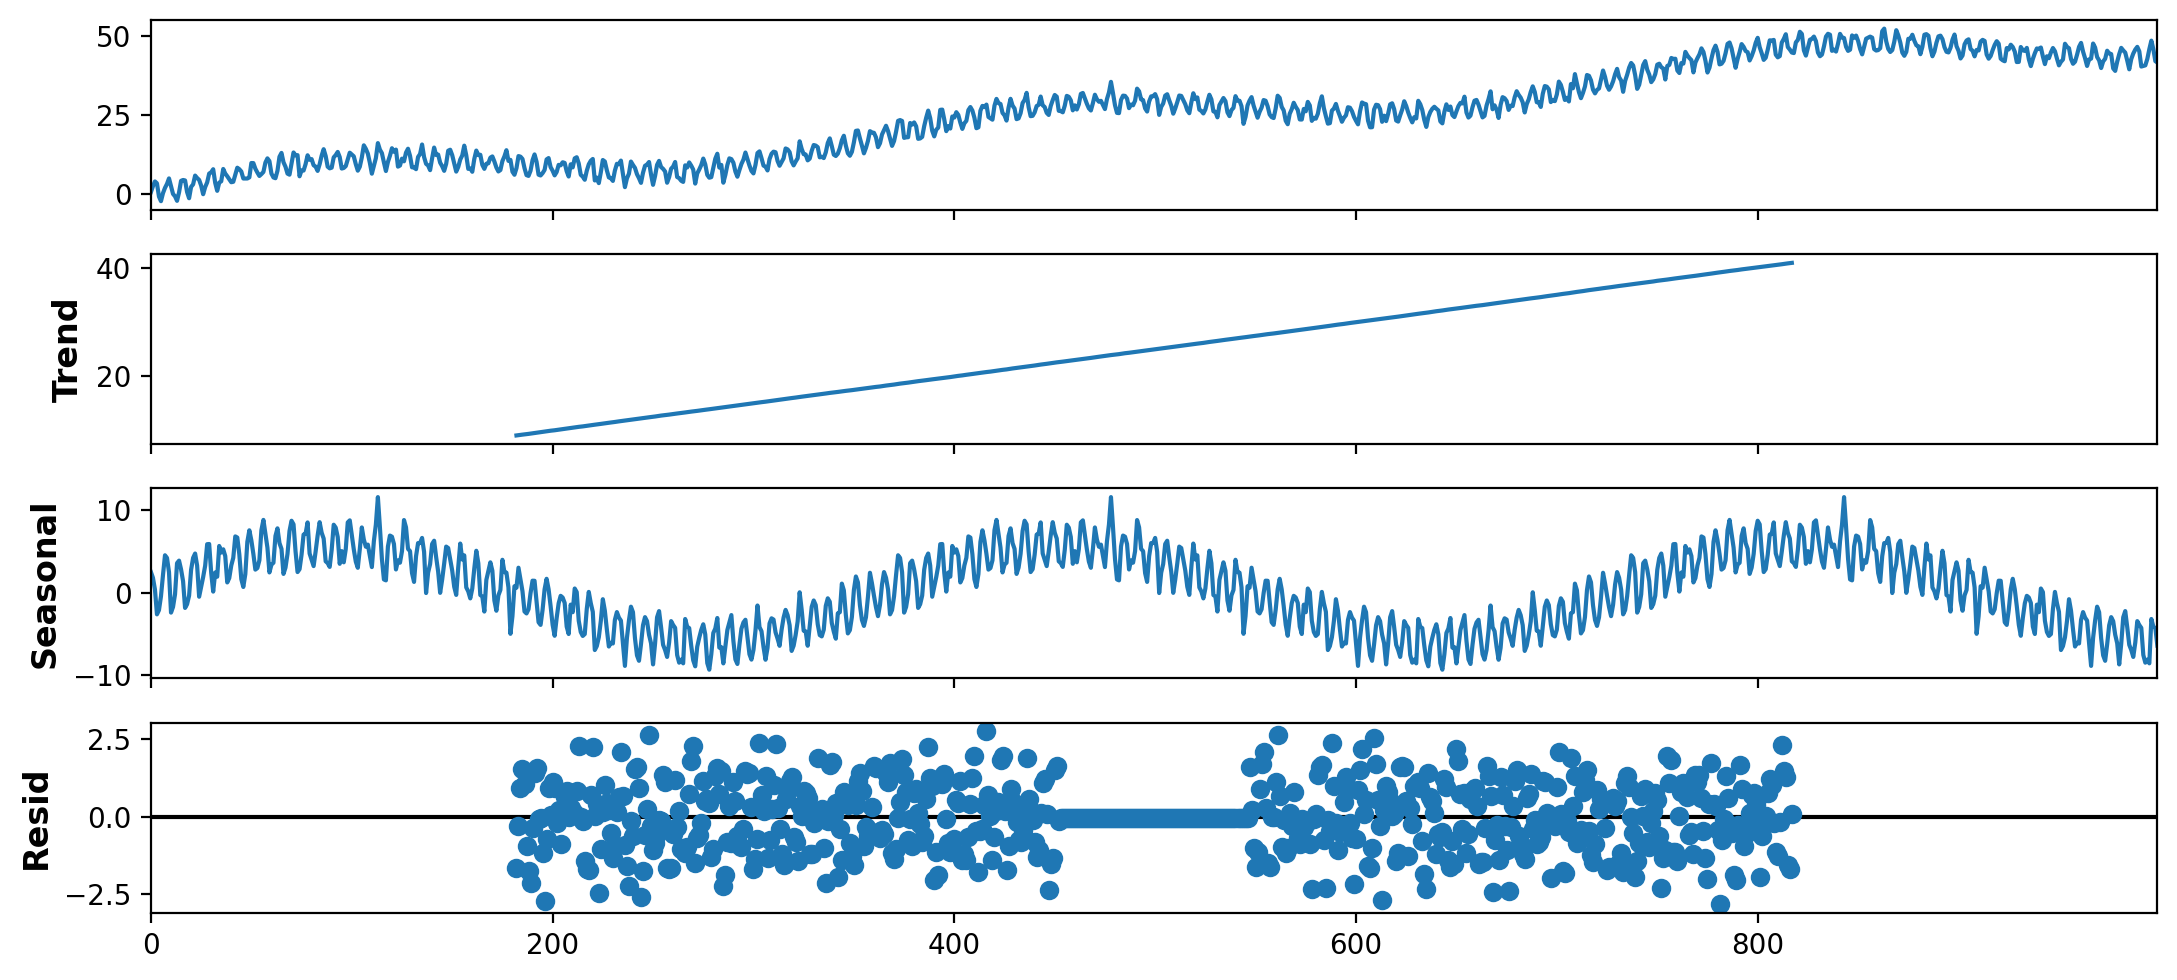

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'data' is your time series (as a pandas Series)
decomposition = seasonal_decompose(data, model='additive', period=365)  # period=365 for yearly seasonality
decomposition.plot()
plt.show()


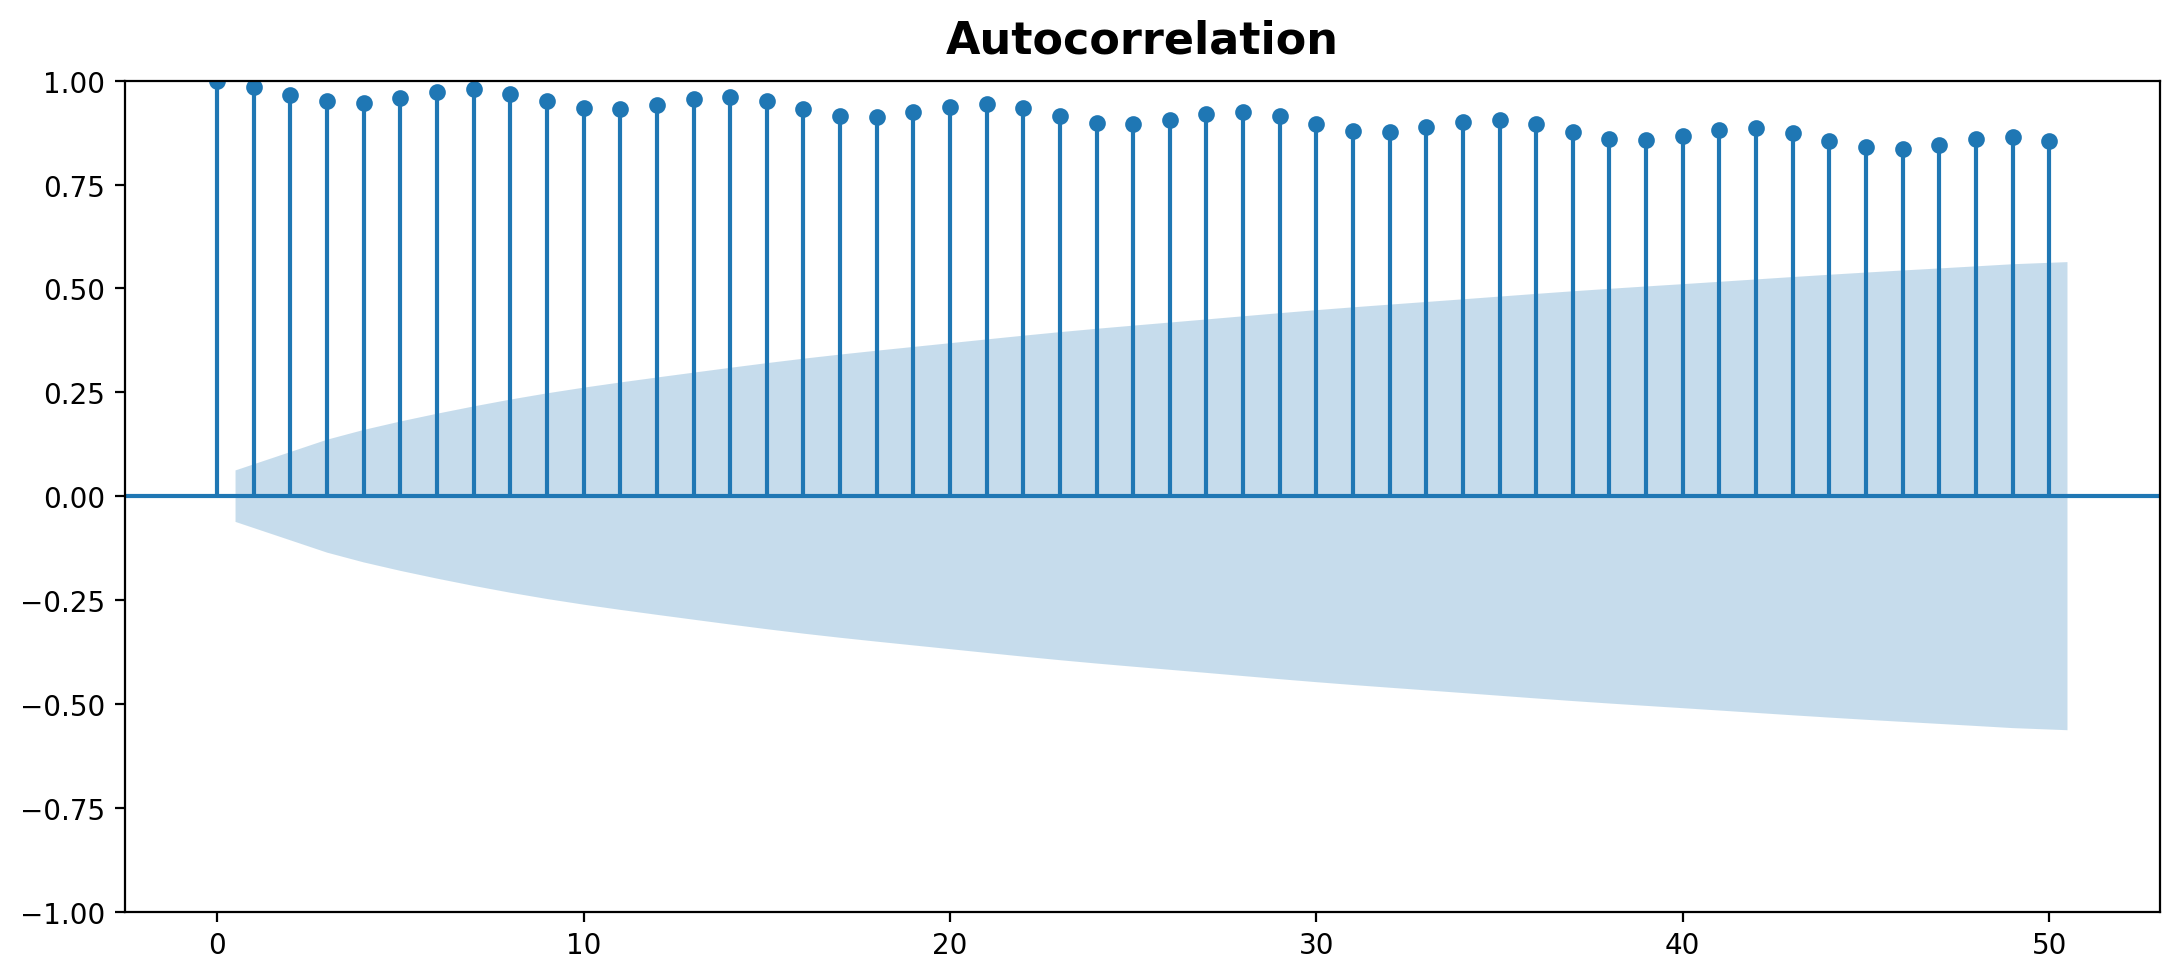

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, lags=50)  # Adjust lags according to your data's frequency
plt.show()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

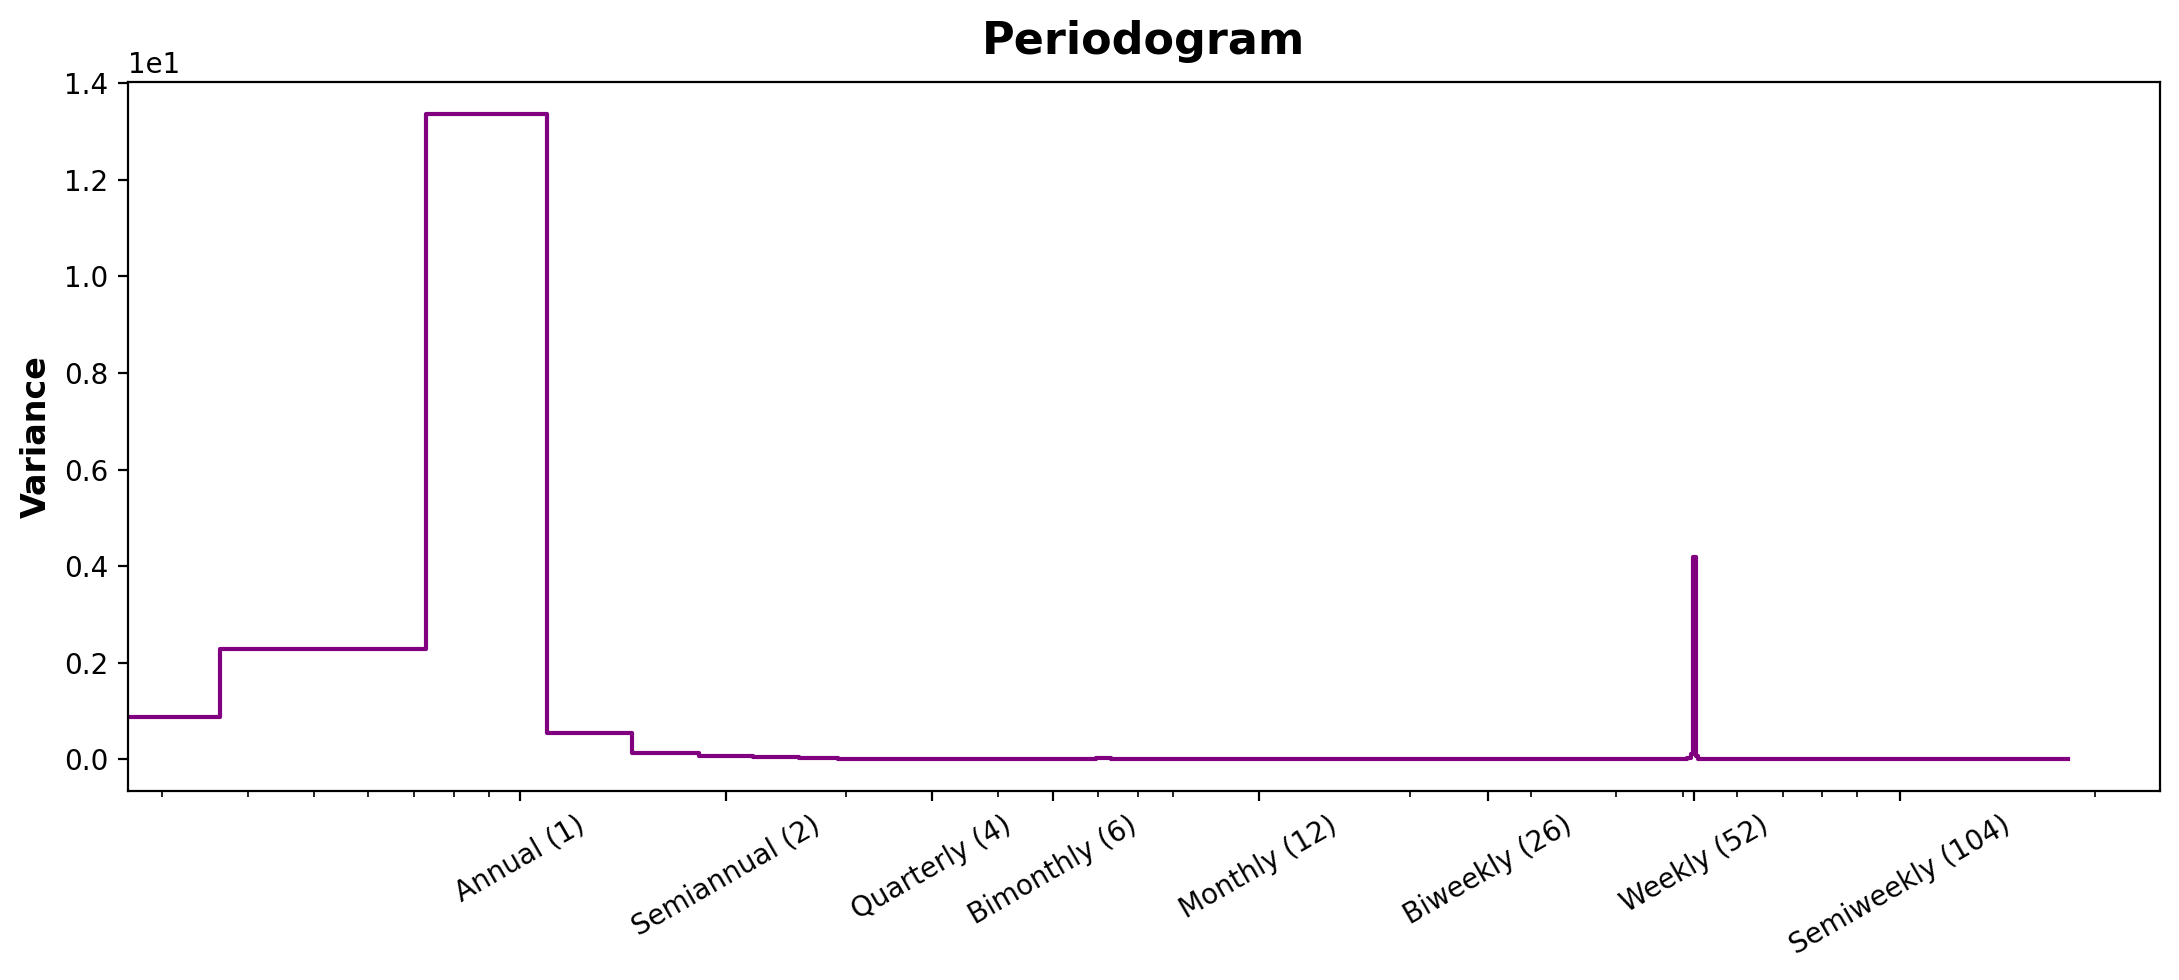

In [40]:
plot_periodogram(data['value'])

## The use of exogenous variables

They must be availabe for forecast
They should be sincronized with the data

### Checking for stationarity

The null test is that is it non-stationary, so if the value p is less than 0.05, it is stationary.

In [45]:
from statsmodels.tsa.stattools import adfuller

detrended_data = data - data.rolling(window=12, center=True).mean()
result = adfuller(detrended_data.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -6.897981271543
p-value: 1.3039461261946077e-09


For checking the stationarity, we need to detrend and deseasonalize the data.

To deseasonalize the data, we just need to difference the data by the seasonality.

In [46]:
data_diff = data.diff(12)